In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets import TranslationDataset, Multi30k, IWSLT, WMT14
from torchtext.data import Field, BucketIterator, Iterator
import spacy
import numpy as np
import random
import math
import time
from collections import defaultdict
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import itertools

In [0]:
%%capture
!python3 -m spacy download en
!python3 -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sos_token='<sos>'
eos_token='<eos>'
pad_token='<pad>'
unk_token='<unk>'

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [0]:
TRG = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_en,
            pad_token=pad_token, 
            unk_token=unk_token)

SRC = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_de,
            pad_token=pad_token, 
            unk_token=unk_token)

In [0]:
%%capture
train_data, valid_data, test_data = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        filter_pred=lambda x: len(x.__dict__['src']) <= 50)

In [0]:
SRC.build_vocab(train_data, max_size=10000)
TRG.build_vocab(train_data, max_size=10000)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
BATCH_SIZE = 80

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=lambda x: len(x.__dict__['src']),
    batch_size = BATCH_SIZE, 
    device = device)

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden[-1,:,:].unsqueeze(0)

In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

In [0]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 600

In [0]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
enc_dec = EncoderDecoder(enc, dec, device).to(device)

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'bias' in name:
            nn.init.zeros_(param.data)
        elif 'rnn.weight' in name:
            nn.init.orthogonal_(param.data)
        else:
            nn.init.normal_(param.data, mean=0, std=0.01)

In [0]:
enc_dec.apply(init_weights)
ed_optimizer = optim.Adam(enc_dec.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 10
CLIP = 1

for epoch in range(N_EPOCHS):
    torch.save(enc_dec.state_dict(), f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{epoch}.pt')
    enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{epoch}.pt'))

    start_time = time.time()
    train_loss = train(enc_dec, train_iterator, ed_optimizer, criterion, CLIP)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')

torch.save(enc_dec.state_dict(), f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{N_EPOCHS}.pt')
enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{N_EPOCHS}.pt'))

Epoch: 01 | Time: 11m 49s
	Train Loss: 4.709
Epoch: 02 | Time: 11m 49s
	Train Loss: 3.808
Epoch: 03 | Time: 11m 48s
	Train Loss: 3.432
Epoch: 04 | Time: 11m 50s
	Train Loss: 3.194
Epoch: 05 | Time: 11m 48s
	Train Loss: 3.012
Epoch: 06 | Time: 11m 49s
	Train Loss: 2.885
Epoch: 07 | Time: 11m 48s
	Train Loss: 2.771
Epoch: 08 | Time: 11m 49s
	Train Loss: 2.670
Epoch: 09 | Time: 11m 49s
	Train Loss: 2.581
Epoch: 10 | Time: 11m 51s
	Train Loss: 2.512


<All keys matched successfully>

In [0]:
def evaluate_bleu(model, datasets):
    overall_size = sum([len(d) for d in datasets])
    total = 0.0
    for i, example in enumerate(itertools.chain(*datasets)):
        pred = model.translate(example.src)[1:-2]
        total += sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        if i % 200 == 199: print('.', end='')
    print('')
    return total / overall_size

In [0]:
valid_bleu = [0.0]
for i in range(1, 11):
    enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{i}.pt'))
    valid_bleu.append(evaluate_bleu(enc_dec, [valid_data]))

....
....
....
....
....
....
....
....
....
....


In [0]:
test_11, test_12, test_13 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TED.tst2011',
                        validation='IWSLT16.TED.tst2012',
                        test='IWSLT16.TED.tst2013',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)
test_13x, test_14x, test_14 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TEDX.tst2013',
                        validation='IWSLT16.TEDX.tst2014',
                        test='IWSLT16.TED.tst2014',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)
test_10, valid_10, valid_12 = IWSLT.splits(exts = ('.de', '.en'), 
                                fields = (SRC, TRG),
                                train='IWSLT16.TED.tst2010',
                                test='IWSLT16.TED.dev2010',
                                validation='IWSLT16.TEDX.dev2012',
                                filter_pred=lambda x: len(x.__dict__['src']) <= 60)

In [0]:
def bleu_summary(model, datasets):
    overall_examples = sum([len(d) for d in datasets])

    lengths = np.zeros(overall_examples, dtype=np.int32)
    scores = np.zeros(overall_examples)

    for i, example in enumerate(itertools.chain(*datasets)):
        pred = model.translate(example.src)
        scores[i] = sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        lengths[i] = len(example.src)
        if i % 900 == 899: print('.', end='')
        
    print('')
    means, up, lo = {}, {}, {}
    uniq_lengths, counts = np.unique(lengths, return_counts=True)
    for l, c in zip(uniq_lengths, counts):
        s = scores[lengths == l]
        means[l] = s.mean()
        up[l] = means[l] + (np.sqrt(s.var() / c) * 1.65)
        lo[l] = means[l] - (np.sqrt(s.var() / c) * 1.65)

    uniq_lengths = [l for l in sorted(uniq_lengths)]
    return uniq_lengths, [means[l] for l in uniq_lengths], [up[l] for l in uniq_lengths], [lo[l] for l in uniq_lengths]

In [0]:
valid_bleu

[0.0,
 0.004945555615142143,
 0.022827824133190473,
 0.03663412584253686,
 0.05892029439189763,
 0.06623316018397668,
 0.0774073814285976,
 0.08313379205833173,
 0.08702861101040837,
 0.08766192030981368,
 0.08546818534590968]

..........


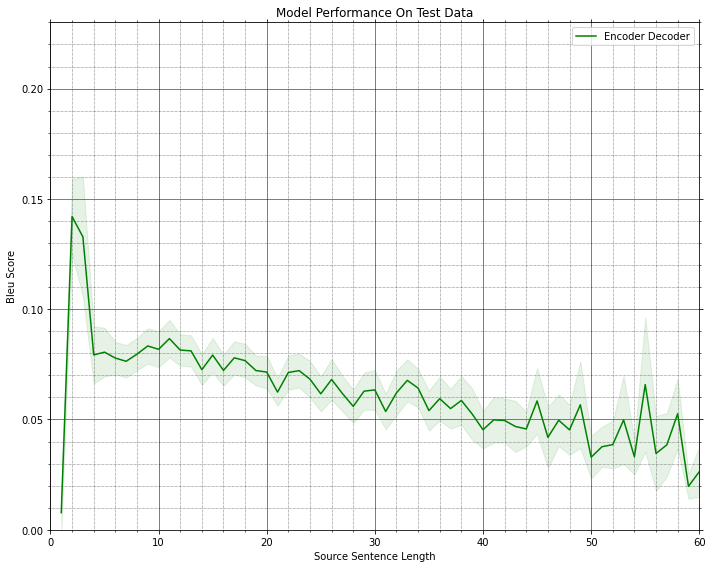

In [0]:
# enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-9.pt'))

ed, ed_m, ed_u, ed_l = bleu_summary(enc_dec, [test_10, test_11, test_12, test_13, test_13x, test_14x, test_14])
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

ax.set_ylabel('Bleu Score')
ax.set_xlabel('Source Sentence Length')
ax.plot(ed, ed_m, color='g', label="Encoder Decoder")
ax.fill_between(ed, ed_l, ed_u, color='g', alpha=0.1)
# ax.plot(se, se_m, color='b', label="Search")
# ax.fill_between(se, se_l, se_u, color='b', alpha=0.1)
ax.set_title('Model Performance On Test Data')
ax.legend()
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.23)

fig.tight_layout()
plt.show()